In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import linear_model

In [2]:
# 1. csv 파일 loading
df = pd.read_csv('../data/ozone.csv')
training_data = df[['Temp', 'Ozone']]

# 2. 결측치 확인 및 제거
print('오존의 결측치 : {}개'.format(training_data['Ozone'].isnull().sum()))
print('온도의 결측치 : {}개'.format(training_data['Temp'].isnull().sum()))

training_data = training_data.dropna(how='any')

display(training_data)

오존의 결측치 : 37개
온도의 결측치 : 0개


,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


In [3]:
# 3. 이상치 확인 및 제거

# 이상치 처리 (이상치 제거)
# z-scroe 이용
zscore_threshold = 1.8

# temp 확인
tmp = ~(np.abs(stats.zscore(training_data['Temp'])) > zscore_threshold)
training_data = training_data.loc[tmp]

# Ozone 확인
tmp = ~(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)
training_data = training_data.loc[tmp]

# sklearn용 정규화 이전 데이터
training_data_sk = training_data.copy()

In [4]:
# 4. Normalization (min- max)
training_data.loc[:,['Temp']] = (training_data['Temp'] - training_data['Temp'].min()) / (training_data['Temp'].max() - training_data['Temp'].min())
training_data.loc[:,['Ozone']] = (training_data['Ozone'] - training_data['Ozone'].min()) / (training_data['Ozone'].max() - training_data['Ozone'].min())
display(training_data)

,Temp,Ozone
0,0.181818,0.397849
1,0.333333,0.344086
2,0.393939,0.086022
3,0.030303,0.150538
5,0.151515,0.258065
...,...,...
147,0.060606,0.107527
148,0.272727,0.279570
150,0.424242,0.107527
151,0.454545,0.150538


In [5]:
# 5. training data set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

## 1. Tensorflow를 이용한 ML

In [6]:
# placeholder
X = tf.placeholder(shape=[None,1], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# W & b
W = tf.Variable(tf.random.normal([1,1]))
b = tf.Variable(tf.random.normal([1]))

# model
H = tf.matmul(X, W) + b

# loss function
loss = tf.reduce_mean(tf.square(H - T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
# learning
for step in range(300000):
    
    _,W_val,b_val,loss_val = sess.run([train,W,b,loss], 
                                      feed_dict={X : x_data, T : t_data})
    
    if step % 30000 == 0:
        print('W :{}, b : {}, loss : {}'.format(W_val,b_val,loss_val))

W :[[-0.35738635]], b : [0.92003787], loss : 0.26668471097946167
W :[[-0.15317588]], b : [0.4587763], loss : 0.09093088656663895
W :[[0.102688]], b : [0.32180512], loss : 0.06262338161468506
W :[[0.28952]], b : [0.2219118], loss : 0.047538142651319504
W :[[0.42590895]], b : [0.14898938], loss : 0.03949901834130287
W :[[0.52547604]], b : [0.09575495], loss : 0.03521479293704033
W :[[0.5981506]], b : [0.05690063], loss : 0.032931968569755554
W :[[0.651184]], b : [0.02853818], loss : 0.03171565756201744
W :[[0.68991613]], b : [0.00783747], loss : 0.031067170202732086
W :[[0.7181767]], b : [-0.00726961], loss : 0.03072165511548519


## 2. Python을 이용한 ML

In [8]:
# W & b
W_p = np.random.rand(1,1)
b_p = np.random.rand(1)

# model
def predict(x):
    
    y = np.dot(x, W_p) + b_p
    
    return y

# loss function
def loss_func(input_obj):
    
    input_W = input_obj[0]
    input_b = input_obj[1]
    
    y = np.dot(x_data, input_W) + input_b
    
    return np.mean(np.power((t_data - y), 2))

# 편미분 함수
def numerical_derivative(f, x):
    
    delta_x = 1e-4
    derivative_x = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'])
    
    while not it.finished:
        
        idx = it.multi_index 
        
        tmp = x[idx] 
        x[idx] = tmp + delta_x
        fx_plus_delta = f(x) 
        
        x[idx] = tmp - delta_x
        fx_minus_delta = f(x) 
        
        derivative_x[idx] = (fx_plus_delta - fx_minus_delta) / (2 * delta_x)
        
        x[idx] = tmp
        
        it.iternext()
        
    return derivative_x

In [15]:
# learning rate and learning
learning_rate = 1e-4

for step in range(600000):

    input_param = np.concatenate((W_p.ravel(), b_p.ravel()), axis=0) # [W b]
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)
    
    W_P = W_p - derivative_result[:1].reshape(1,1)
    b_p = b_p - derivative_result[1:]
    
    if step % 60000 == 0:
        print('W : {}, b : {}'.format(W_p,b_p))

W : [[0.07093841]], b : [0.31848234]
W : [[0.07093841]], b : [0.31848234]
W : [[0.07093841]], b : [0.31848234]
W : [[0.07093841]], b : [0.31848234]
W : [[0.07093841]], b : [0.31848234]
W : [[0.07093841]], b : [0.31848234]
W : [[0.07093841]], b : [0.31848234]
W : [[0.07093841]], b : [0.31848234]
W : [[0.07093841]], b : [0.31848234]
W : [[0.07093841]], b : [0.31848234]


## 3. Sklearn을 이용한 ML

In [10]:
unscaled_x_data = training_data_sk['Temp'].values.reshape(-1,1)
unscaled_t_data = training_data_sk['Ozone'].values.reshape(-1,1)
# linear regression model 생성
model = linear_model.LinearRegression()

# learning
model.fit(unscaled_x_data, unscaled_t_data)

# Weight, bias 확인
print('W : {}, b : {}'.format(model.coef_, model.intercept_))

W : [[2.23956713]], b : [-137.09451328]


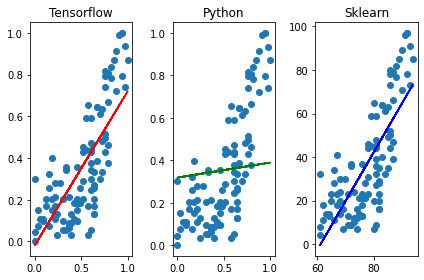

In [13]:
# 7. graph를 그려 차이 확인
fig = plt.figure()
fig_tensorflow = fig.add_subplot(1,3,1)
fig_python = fig.add_subplot(1,3,2)
fig_sklearn = fig.add_subplot(1,3,3)

fig_tensorflow.set_title('Tensorflow')
fig_tensorflow.scatter(x_data, t_data)
fig_tensorflow.plot(x_data, x_data*W_val + b_val, color='r')

fig_python.set_title('Python')
fig_python.scatter(x_data, t_data)
fig_python.plot(x_data, x_data*W_p + b_p, color='g')

fig_sklearn.set_title('Sklearn')
fig_sklearn.scatter(unscaled_x_data, unscaled_t_data)
fig_sklearn.plot(unscaled_x_data, unscaled_x_data*model.coef_ + model.intercept_, color='b')

fig.tight_layout()

In [12]:
# 8. 예측치 비교
# temp = 82로 비교
predict_temp = np.array([[82]])
scaled_predict_temp = (predict_temp - training_data['Temp'].min()) / (training_data['Temp'].max() - training_data['Temp'].min())

predict_tensorflow = sess.run(H, feed_dict={X : scaled_predict_temp})
predict_python = predict(scaled_predict_temp)

result_tensorflow = (predict_tensorflow * (training_data['Temp'].max() - training_data['Temp'].min())) + training_data['Temp'].min()
result_python = (predict_python * (training_data['Temp'].max() - training_data['Temp'].min())) + training_data['Temp'].min()

print('tensorflow : {}'.format(result_tensorflow))
print('python : {}'.format(result_python))
print('sklearn : {}'.format(model.predict(predict_temp)))

tensorflow : [[60.55933]]
python : [[6.13543173]]
sklearn : [[46.5499913]]
